In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

# Functions

## Create activity dataframe

In [8]:
def create_activities_df(path):
    """ A function for creating a dataframe containing information about the beginning, end and name of each physical activity
    Args:
        1) path - the path to the Label Studio file that contains the labeled signals
    Returns:
        Dataframe containing information about the beginning, end and name of each physical activity
    """
    labeled_activities = pd.read_csv(path)
    labels = labeled_activities['label']
    labels = np.array(labels)[0]    # the original type of labels is pd.Series
    labels = labels.split('},')
    
    activities_dict = {'start_time': [], 'end_time': [], 'activity': []}
    for label in labels:
        start_time, end_time, _, activity = label.split(',')
        activities_dict['start_time'].append(float(start_time.split(':')[1]))
        activities_dict['end_time'].append(float(end_time.split(':')[1]))
        activities_dict['activity'].append(activity.split(':')[1].strip('[]}"'))
    
    activities_df = pd.DataFrame.from_dict(activities_dict)
    activities_df = activities_df.sort_values(by='start_time').reset_index(drop=True)
    return activities_df

def add_activity_column(path, df, df_merge_col):
    """ Function to add 'activity' column to dataframe df
    Args:
        1) path - the path to the Label Studio file that contains the labeled signals
        2) df - a dataframe that contains the results of accelerometer and gyroscope measurements
        3) df_merge_col - the name of the column of the dataframe df, which contains data about the measurement time ('time' column)
    """
    activities_df_local = create_activities_df(path)
    merged_df = pd.merge_asof(df, activities_df_local, left_on=df_merge_col, right_on='start_time', direction='backward')
    df['activity'] = merged_df['activity']
    
    
def display_activity_freq_spectrum_one_axes(df, activity_name, axes_name, sampling_rate, is_divided_by_g=False, x_lim=10, color='blue'):
    """ Function to display the frequency spectrum of the specified type of activity on the OX, OY and OZ axes for the specified device 
    (accelerometer or gyroscope)
    Args:
        1) df - a dataframe that contains the results of accelerometer and gyroscope measurements
        2) activity_name - selected activity type (among the values of the 'activity' column of df)
        3) axes_name - the column name of the dataframe df that contain the measurement results for the OX, OY, or OZ axes
        4) sampling_rate - actual sampling rate of your dataset (samples per second)
        5) is_divided_by_g - True if the content of the column was divided by the free fall acceleration g (g=9.81 m/s^2)
        6) x_lim - the limits of the graph along the OX axis are [-x_lim; x_lim]
        7) color - the color of the graph
    """
    activity_data = df[df['activity'] == activity_name]
    
    signal = np.array(activity_data[axes_name])
    
    if is_divided_by_g:
        signal *= 9.81
        
    fft_result = fft(signal)

    fft_freqs = fftfreq(len(activity_data), 1/sampling_rate)

    fig = plt.figure(figsize=(12, 5))
    axes = fig.add_axes([0.1, 0.1, 1, 1])
    axes.plot(fft_freqs, np.abs(fft_result), color=color)
    axes.set_title(f'{activity_name} {axes_name}')

    axes.set_xlabel('Frequency (Hz)')
    axes.set_xlim(-x_lim, x_lim)
    axes.set_ylabel('Amplitude')
    axes.grid(alpha=0.5)

    plt.show()

    
def display_activity_freq_spectrum(df, activity_name, axes_names, sampling_rate, is_divided_by_g=False, x_lim=10):
    """ Function to display the frequency spectrum of the specified type of activity on the OX, OY and OZ axes for the specified device 
    (accelerometer or gyroscope)
    Args:
        1) df - a dataframe that contains the results of accelerometer and gyroscope measurements
        2) activity_name - selected activity type (among the values of the 'activity' column of df)
        3) axes_names - an array containing the column names of the dataframe df that contain the measurement results for the OX, OY, and OZ axes, 
        respectively
        4) sampling_rate - actual sampling rate of your dataset (samples per second)
        5) is_divided_by_g - True if the content of the column was divided by the free fall acceleration g (g=9.81 m/s^2)
        6) x_lim - the limits of the graph along the OX axis are [-x_lim; x_lim]
    """
    activity_data = df[df['activity'] == activity_name]
    
    signal_x = np.array(activity_data[axes_names[0]])
    signal_y = np.array(activity_data[axes_names[1]])
    signal_z = np.array(activity_data[axes_names[2]])
    
    if is_divided_by_g:
        signal_x *= 9.81
        signal_y *= 9.81
        signal_z *= 9.81
        
    fft_x = fft(signal_x)
    fft_y = fft(signal_y)
    fft_z = fft(signal_z)

    fft_freqs = fftfreq(len(activity_data), 1/sampling_rate)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].plot(fft_freqs, np.abs(fft_x), label='X', color='blue')
    axes[0].set_title(f'{activity_name} {axes_names[0]}')

    axes[1].plot(fft_freqs, np.abs(fft_y), label='Y', color='yellow')
    axes[1].set_title(f'{activity_name} {axes_names[1]}')

    axes[2].plot(fft_freqs, np.abs(fft_z), label='Z', color='green')
    axes[2].set_title(f'{activity_name} {axes_names[2]}')

    for ax in axes:
        ax.set_xlabel('Frequency (Hz)')
        ax.set_xlim(-x_lim, x_lim)
        ax.set_xticks([i for i in range(-x_lim, x_lim+1, 2)])
        ax.set_ylabel('Amplitude')
        ax.grid(alpha=0.5)
        ax.legend()

    plt.tight_layout()
    plt.show()

## Visualizing results

In [2]:
def display_three_axes(df, y, x=None, title=None, x_label=None, y_label=None, filename=None):
    """ Function for visualization of three axes (X, Y, Z) of the measurement results of the device
    Args:
        1) df - a dataframe containing the results of the device measurement
        2) x - the name of the column of the dataframe that contains the data for the OX axis (for the three lines, this is the same data)
        3) y - the list containing the dataframe column names corresponding to the OX, OY, and OZ axis measurements, respectively
        4) title - title of the graph
        5) x_label - the name of the OX axis of the graph
        6) y_label - the name of the OY axis of the graph
        7) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    Returns:
        Nothing, but plots graph
    """
    plt.figure(figsize=(12, 6))
    if x is None:
        plt.plot(df[y[0]], label='X')
        plt.plot(df[y[1]], label='Y')
        plt.plot(df[y[2]], label='Z')
    else:
        plt.plot(df[x], df[y[0]], label='X')
        plt.plot(df[x], df[y[1]], label='Y')
        plt.plot(df[x], df[y[2]], label='Z')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    if filename:
        plt.savefig(f'{filename}.png', bbox_inches='tight')
    plt.show()
    

def display_three_axes_sep(df, x, y, title=None, x_label=None, y_labels=None):
    """ Function for visualization of three axes (X, Y, Z) of the measurement results of the device, a separate graph for each axis
    Args:
        1) df - a dataframe containing the results of the device measurement;
        2) x - the name of the column of the dataframe that contains the data for the OX axis (for the three lines, this is the same data);
        3) y - the list containing the dataframe column names corresponding to the OX, OY, and OZ axis measurements, respectively;
        4) title - title of the graph;
        5) x_label - the name of the OX axis of the graph;
        6) y_labels - the list of names of the OY axis of the graph.
    Returns:
        Nothing, but plots graph
    """
    fig, axes = plt.subplots(3, 1, figsize=(10, 18))
    axes[0].plot(df[x], df[y[0]], color='blue')
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_labels[0])
    axes[0].set_title(title + ' accX')

    axes[1].plot(df[x], df[y[1]], color='yellow')
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel(y_labels[1])
    axes[1].set_title(title + ' accY')

    axes[2].plot(df[x], df[y[2]], color='green')
    axes[2].set_xlabel(x_label)
    axes[2].set_ylabel(y_labels[2])
    axes[2].set_title(title + ' accZ')

    plt.show()

## Feature engineering

In [9]:
def add_statistical_measures_columns(X_df, data_df, X_df_columns_add, data_df_columns_add):
    """Function to add columns, which contains statistical measures, to X_df
    Args:
        1) X_df - the dataframe to which the new columns will be added;
        2) data_df - a dataframe that contains arrays with data needed to calculate statistical measures;
        3) X_df_columns_add - a suffix that specifies what the new columns of X_df will be named 
           (for example, for the suffix 'accel', the first 3 columns will be named 'accel_x_mean', 'accel_y_mean' and 'accel_z_mean');
        4) data_df_columns_add - a suffix that determines from which columns of the data frame data_df the necessary data for calculating 
           statistical measures will be taken.
           For example, if you need to calculate statistical parameters for the accelerometer, you should specify a suffix as the beginning
           of the name of the accelerometer readings in the data_df dataframe, in particular 'gF'.
    """
    # mean
    X_df[f'{X_df_columns_add}_x_mean'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: x.mean())
    X_df[f'{X_df_columns_add}_y_mean'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: x.mean())
    X_df[f'{X_df_columns_add}_z_mean'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: x.mean())

    # variation
    X_df[f'{X_df_columns_add}_x_variation'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.std(x, ddof=0) / np.mean(x))
    X_df[f'{X_df_columns_add}_y_variation'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.std(x, ddof=0) / np.mean(x))
    X_df[f'{X_df_columns_add}_z_variation'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.std(x, ddof=0) / np.mean(x))

    # std deviation
    X_df[f'{X_df_columns_add}_x_std'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: x.std())
    X_df[f'{X_df_columns_add}_y_std'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: x.std())
    X_df[f'{X_df_columns_add}_z_std'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: x.std())

    # avg absolute diff
    X_df[f'{X_df_columns_add}_x_aad'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_df[f'{X_df_columns_add}_y_aad'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_df[f'{X_df_columns_add}_z_aad'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

    # min
    X_df[f'{X_df_columns_add}_x_min'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: x.min())
    X_df[f'{X_df_columns_add}_y_min'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: x.min())
    X_df[f'{X_df_columns_add}_z_min'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: x.min())

    # max
    X_df[f'{X_df_columns_add}_x_max'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: x.max())
    X_df[f'{X_df_columns_add}_y_max'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: x.max())
    X_df[f'{X_df_columns_add}_z_max'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: x.max())

    # max-min diff
    X_df[f'{X_df_columns_add}_x_maxmin_diff'] = X_df[f'{X_df_columns_add}_x_max'] - X_df[f'{X_df_columns_add}_x_min']
    X_df[f'{X_df_columns_add}_y_maxmin_diff'] = X_df[f'{X_df_columns_add}_y_max'] - X_df[f'{X_df_columns_add}_y_min']
    X_df[f'{X_df_columns_add}_z_maxmin_diff'] = X_df[f'{X_df_columns_add}_z_max'] - X_df[f'{X_df_columns_add}_z_min']

    # median
    X_df[f'{X_df_columns_add}_x_median'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.median(x))
    X_df[f'{X_df_columns_add}_y_median'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.median(x))
    X_df[f'{X_df_columns_add}_z_median'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.median(x))

    # median abs dev 
    X_df[f'{X_df_columns_add}_x_mad'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_df[f'{X_df_columns_add}_y_mad'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_df[f'{X_df_columns_add}_z_mad'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.median(np.absolute(x - np.median(x))))

    # interquartile range
    X_df[f'{X_df_columns_add}_x_IQR'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_df[f'{X_df_columns_add}_y_IQR'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_df[f'{X_df_columns_add}_z_IQR'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    # negative count
    X_df[f'{X_df_columns_add}_x_neg_count'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.sum(x < 0))
    X_df[f'{X_df_columns_add}_y_neg_count'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.sum(x < 0))
    X_df[f'{X_df_columns_add}_z_neg_count'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.sum(x < 0))

    # positive count
    X_df[f'{X_df_columns_add}_x_pos_count'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.sum(x > 0))
    X_df[f'{X_df_columns_add}_y_pos_count'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.sum(x > 0))
    X_df[f'{X_df_columns_add}_z_pos_count'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.sum(x > 0))

    # values above mean
    X_df[f'{X_df_columns_add}_x_above_mean'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.sum(x > x.mean()))
    X_df[f'{X_df_columns_add}_y_above_mean'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.sum(x > x.mean()))
    X_df[f'{X_df_columns_add}_z_above_mean'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.sum(x > x.mean()))

    # number of peaks
    X_df[f'{X_df_columns_add}_x_peak_count'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: len(find_peaks(x)[0]))
    X_df[f'{X_df_columns_add}_y_peak_count'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: len(find_peaks(x)[0]))
    X_df[f'{X_df_columns_add}_z_peak_count'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: len(find_peaks(x)[0]))

    # skewness = assymetry
    X_df[f'{X_df_columns_add}_x_assymetry'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: stats.skew(x))
    X_df[f'{X_df_columns_add}_y_assymetry'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: stats.skew(x))
    X_df[f'{X_df_columns_add}_z_assymetry'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: stats.skew(x))

    # kurtosis
    X_df[f'{X_df_columns_add}_x_kurtosis'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: stats.kurtosis(x))
    X_df[f'{X_df_columns_add}_y_kurtosis'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: stats.kurtosis(x))
    X_df[f'{X_df_columns_add}_z_kurtosis'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: stats.kurtosis(x))

    # energy
    X_df[f'{X_df_columns_add}_x_energy'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.sum(x**2)/100)
    X_df[f'{X_df_columns_add}_y_energy'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.sum(x**2)/100)
    X_df[f'{X_df_columns_add}_z_energy'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.sum(x**2/100))

    # avg resultant
    X_df[f'{X_df_columns_add}_avg_result_accl'] = [i.mean() for i in ((data_df[f'{data_df_columns_add}x_s']**2 
                                                   + data_df[f'{data_df_columns_add}y_s']**2 + data_df[f'{data_df_columns_add}z_s']**2)**0.5)]

    # signal magnitude area
    X_df[f'{X_df_columns_add}_sma'] =data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.sum(abs(x)/100)) + data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.sum(abs(x)/100)) + data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.sum(abs(x)/100))

# Work with datasets

## squats_df

In [3]:
columns = ['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
squats_df = pd.read_csv('data/10_Hz/original_data/train/Squats_HIMU-2023-08-15_09-40-12.csv', names=columns, skiprows=4)

squats_df.head()

,accX,accY,accZ,gyrX,gyrY,gyrZ
0,-0.40800,-0.14595,9.844050,4.987537,-6.732138,5.511550
1,-0.36495,-0.12195,9.811050,3.540487,-2.135788,4.027513
2,-0.42705,-0.15795,10.014001,2.065800,-0.555775,1.789150
3,-0.40800,-0.12195,9.655050,0.998250,-0.017188,0.431750
4,-0.43005,-0.21000,10.048051,0.362725,0.018975,0.395037


In [4]:
squats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3072 entries, 0 to 3071
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   accX    3072 non-null   float64
 1   accY    3072 non-null   float64
 2   accZ    3072 non-null   float64
 3   gyrX    3072 non-null   float64
 4   gyrY    3072 non-null   float64
 5   gyrZ    3072 non-null   float64
dtypes: float64(6)
memory usage: 144.1 KB


### Visualise accelerometer and gyroscope behaviour (Raw data)

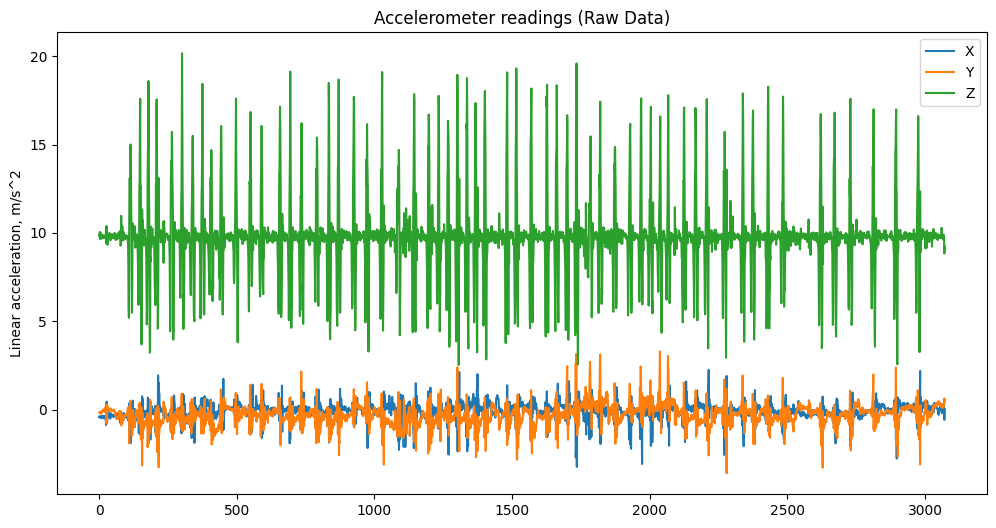

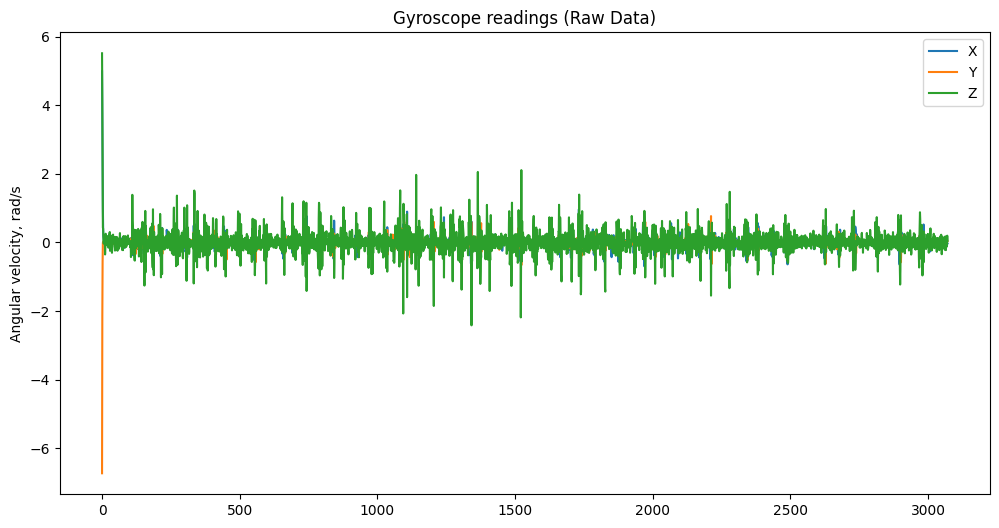

In [6]:
display_three_axes(df=squats_df, y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   y_label='Linear acceleration, m/s^2')
display_three_axes(df=squats_df, y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   y_label='Angular velocity, rad/s')

## leg_land_df

In [7]:
columns = ['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
leg_land_df = pd.read_csv('data/10_Hz/original_data/train/LegLand_HIMU-2023-08-15_09-49-34.csv', names=columns, skiprows=4)

leg_land_df.head()

,accX,accY,accZ,gyrX,gyrY,gyrZ
0,0.21795,-0.23400,9.673950,0.080025,0.148775,-0.111237
1,0.13395,-0.27705,9.724951,-0.032037,-0.166513,0.369325
2,0.20100,-0.34695,9.883051,-0.068062,-0.118663,-0.055825
3,0.22800,-0.43095,9.801001,-0.049087,-0.066000,-0.076037
4,0.45795,-0.76605,10.347000,-0.053213,-0.030662,-0.144100


In [8]:
leg_land_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3635 entries, 0 to 3634
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   accX    3635 non-null   float64
 1   accY    3635 non-null   float64
 2   accZ    3635 non-null   float64
 3   gyrX    3635 non-null   float64
 4   gyrY    3635 non-null   float64
 5   gyrZ    3635 non-null   float64
dtypes: float64(6)
memory usage: 170.5 KB


### Visualise accelerometer and gyroscope behaviour (Raw data)

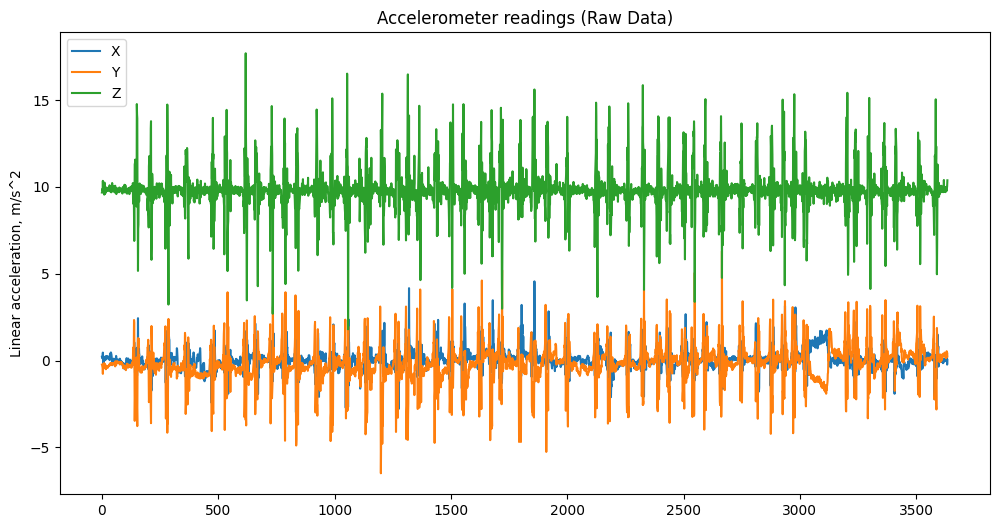

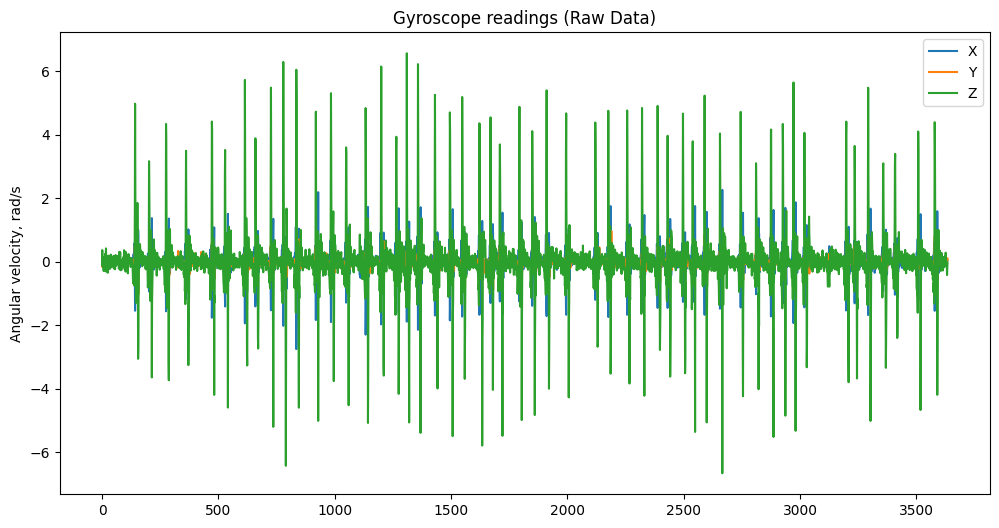

In [9]:
display_three_axes(df=leg_land_df, y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   y_label='Linear acceleration, m/s^2')
display_three_axes(df=leg_land_df, y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   y_label='Angular velocity, rad/s')

## walk_df

In [10]:
columns = ['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
walk_df = pd.read_csv('data/10_Hz/original_data/train/Walk_HIMU-2023-08-16_09-25-42.csv', names=columns, skiprows=4)

walk_df.head()

,accX,accY,accZ,gyrX,gyrY,gyrZ
0,-0.41805,-0.11700,9.907050,-1.029050,1.122412,7.739738
1,-0.22800,-0.34200,9.804001,-0.931287,0.646388,7.430912
2,-0.21600,-0.31305,9.591001,-0.584100,0.160463,3.663137
3,-0.33405,-0.32805,9.993000,-0.288338,-0.070125,1.380087
4,-0.55605,-0.03105,9.661950,-0.204600,-0.069163,0.752400


In [11]:
walk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3508 entries, 0 to 3507
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   accX    3508 non-null   float64
 1   accY    3508 non-null   float64
 2   accZ    3508 non-null   float64
 3   gyrX    3508 non-null   float64
 4   gyrY    3508 non-null   float64
 5   gyrZ    3508 non-null   float64
dtypes: float64(6)
memory usage: 164.6 KB


### Visualise accelerometer and gyroscope behaviour (Raw data)

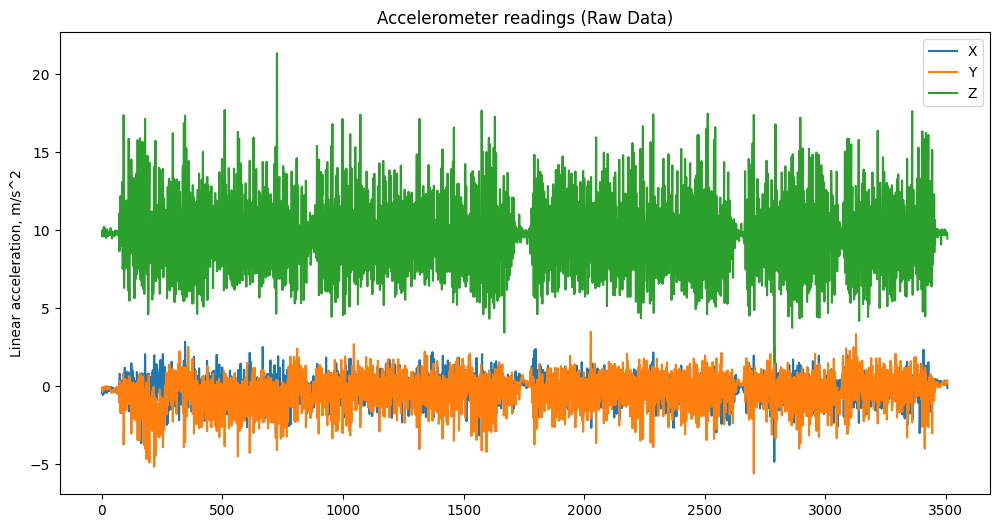

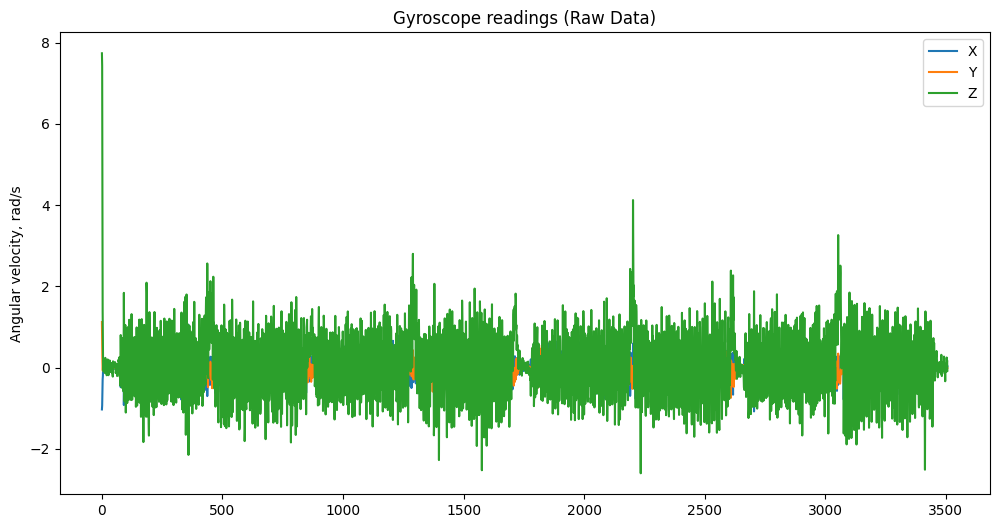

In [12]:
display_three_axes(df=walk_df, y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   y_label='Linear acceleration, m/s^2')
display_three_axes(df=walk_df, y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   y_label='Angular velocity, rad/s')

## lateral_squat_slide_df

In [13]:
columns = ['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
lateral_squat_slide_df = pd.read_csv('data/10_Hz/original_data/train/Lateral_HIMU-2023-08-16_09-36-12.csv', names=columns, skiprows=4)

lateral_squat_slide_df.head()

,accX,accY,accZ,gyrX,gyrY,gyrZ
0,-0.29295,-0.06000,9.76500,-0.302638,0.204600,3.531275
1,-0.35295,-0.04500,9.57900,-0.612563,0.400263,9.535900
2,-0.06105,-0.17895,9.61005,-0.291363,0.079888,3.474487
3,-0.25500,-0.17205,10.14795,-0.167337,-0.129525,0.910663
4,-0.43695,-0.01605,9.70995,-0.055962,-0.044275,0.200750


In [14]:
lateral_squat_slide_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2860 entries, 0 to 2859
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   accX    2860 non-null   float64
 1   accY    2860 non-null   float64
 2   accZ    2860 non-null   float64
 3   gyrX    2860 non-null   float64
 4   gyrY    2860 non-null   float64
 5   gyrZ    2860 non-null   float64
dtypes: float64(6)
memory usage: 134.2 KB


### Visualise accelerometer and gyroscope behaviour (Raw data)

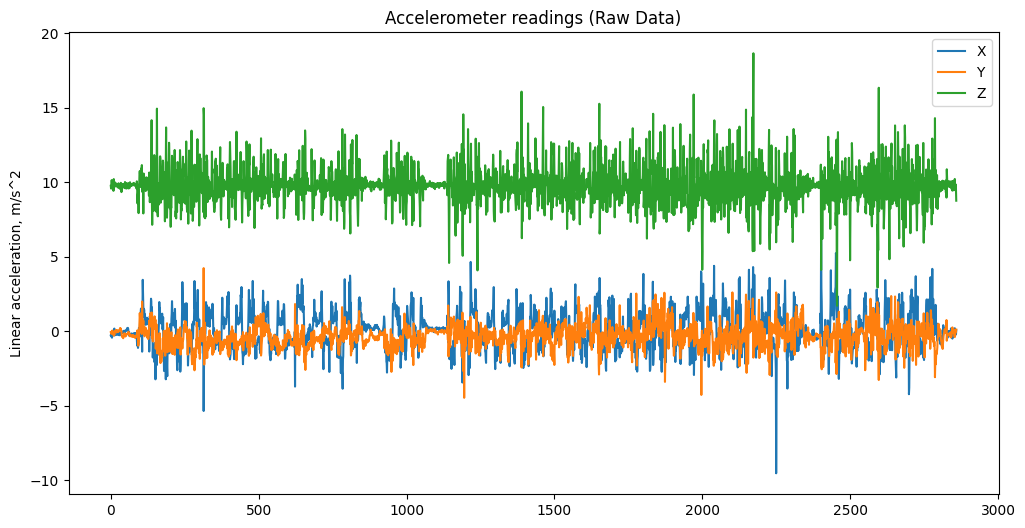

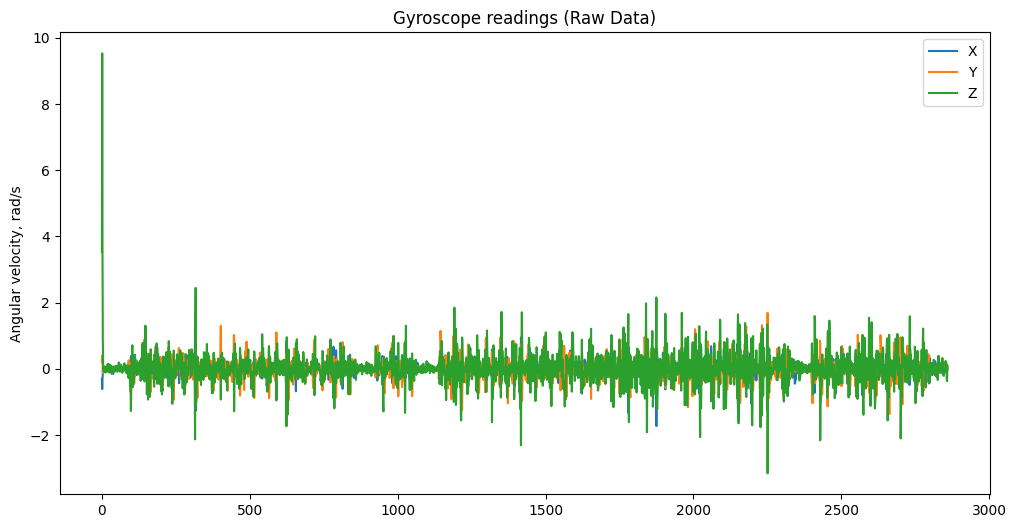

In [15]:
display_three_axes(df=lateral_squat_slide_df, y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   y_label='Linear acceleration, m/s^2')
display_three_axes(df=lateral_squat_slide_df, y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   y_label='Angular velocity, rad/s')

## jogging_df

In [17]:
columns = ['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
jogging_df = pd.read_csv('data/10_Hz/original_data/train/Jogging_HIMU-2023-08-17_09-24-25.csv', names=columns, skiprows=4)

jogging_df.head()

,accX,accY,accZ,gyrX,gyrY,gyrZ
0,-0.70200,-0.27300,10.303950,0.020762,0.023375,-0.155375
1,-0.46800,-0.45705,9.969001,0.019113,0.123613,-0.487300
2,-0.67605,-0.36795,9.844050,0.027088,0.090612,-0.436287
3,-0.68295,-0.31995,9.709950,-0.011275,0.067238,-0.124300
4,-0.76905,-0.22500,9.741000,-0.028463,0.012375,0.140113


In [18]:
jogging_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3154 entries, 0 to 3153
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   accX    3154 non-null   float64
 1   accY    3154 non-null   float64
 2   accZ    3154 non-null   float64
 3   gyrX    3154 non-null   float64
 4   gyrY    3154 non-null   float64
 5   gyrZ    3154 non-null   float64
dtypes: float64(6)
memory usage: 148.0 KB


### Visualise accelerometer and gyroscope behaviour (Raw data)

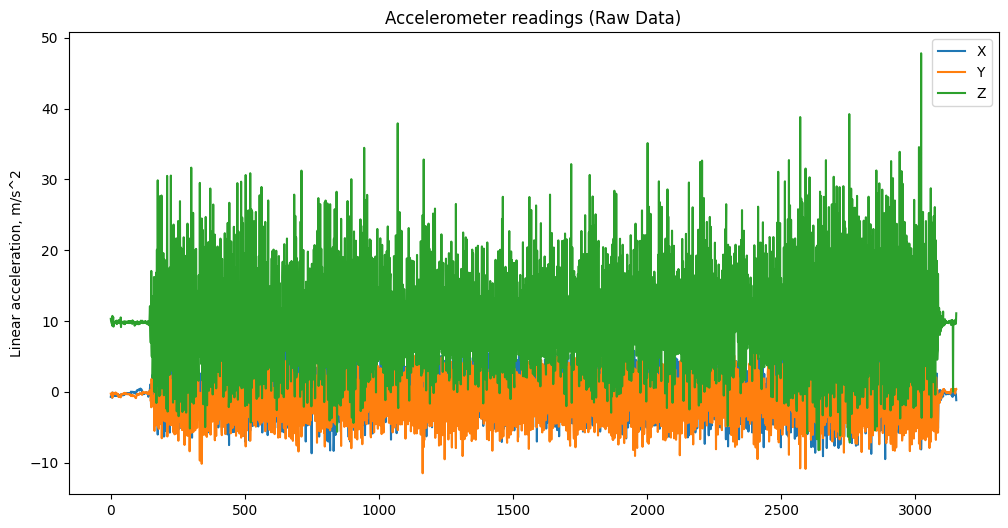

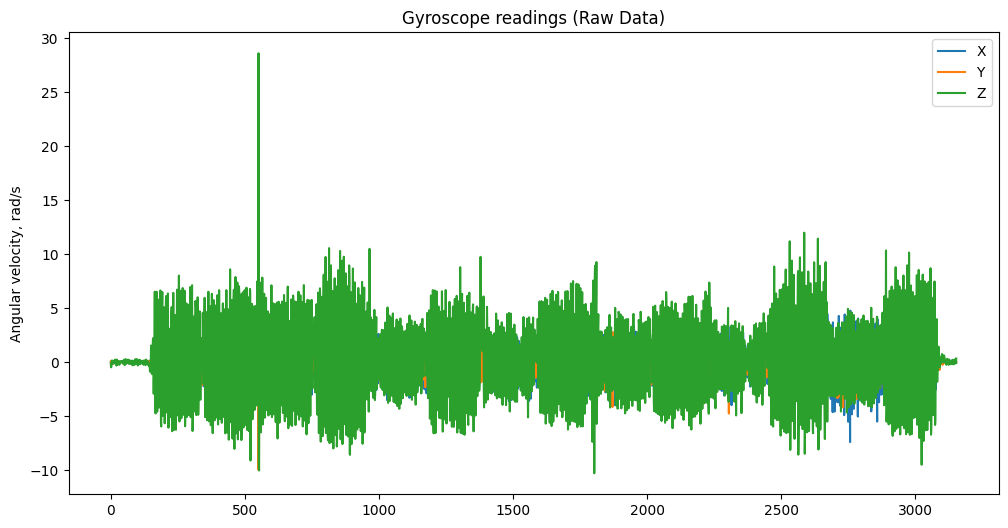

In [19]:
display_three_axes(df=jogging_df, y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   y_label='Linear acceleration, m/s^2')
display_three_axes(df=jogging_df, y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   y_label='Angular velocity, rad/s')

## test_df

In [21]:
columns = ['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
test_df = pd.read_csv('data/10_Hz/original_data/test/Test_HIMU-2023-08-17_09-40-28.csv', names=columns, skiprows=4)

test_df.head()

,accX,accY,accZ,gyrX,gyrY,gyrZ
0,-0.35100,0.28395,9.832050,-0.013750,-0.022138,-0.072050
1,-0.39795,0.31305,10.219951,0.006188,0.010037,-0.021862
2,-0.04395,0.38700,9.540001,0.040975,-0.014850,-0.202400
3,0.08895,-0.07905,10.636950,-0.001512,-0.117837,0.297825
4,-0.51600,0.61395,9.294001,-0.104775,-0.127600,0.234712


In [22]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2857 entries, 0 to 2856
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   accX    2857 non-null   float64
 1   accY    2857 non-null   float64
 2   accZ    2857 non-null   float64
 3   gyrX    2857 non-null   float64
 4   gyrY    2857 non-null   float64
 5   gyrZ    2857 non-null   float64
dtypes: float64(6)
memory usage: 134.0 KB


### Visualise accelerometer and gyroscope behaviour (Raw data)

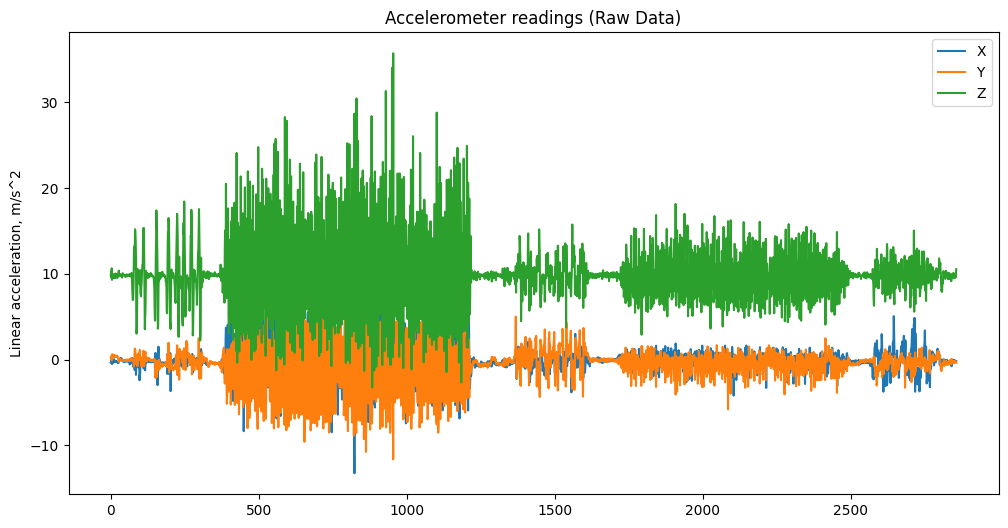

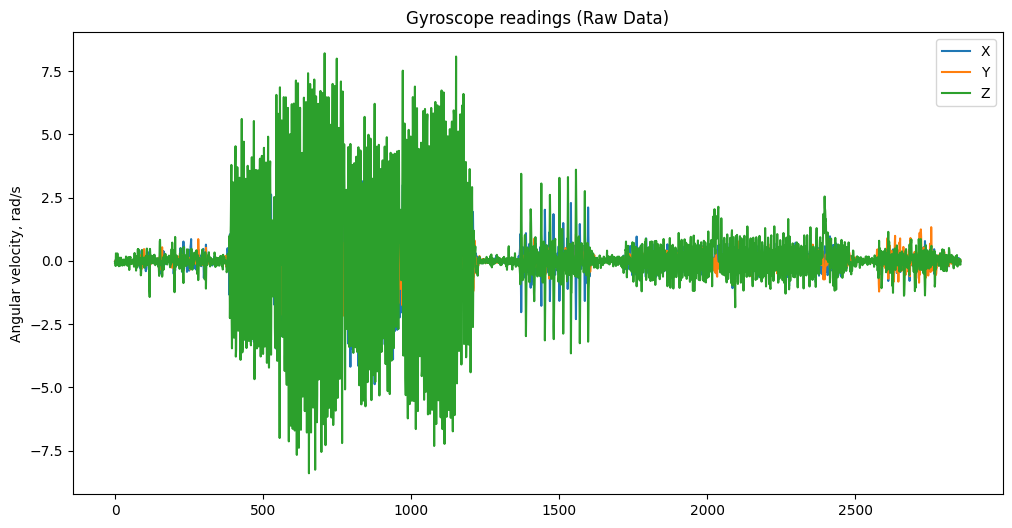

In [23]:
display_three_axes(df=test_df, y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   y_label='Linear acceleration, m/s^2')
display_three_axes(df=test_df, y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   y_label='Angular velocity, rad/s')